# Random Forest

**Author: [Kevin Broløs](https://abzu.ai/team)**

In this notebook, we'll use the Random Forest ensemble method on top of our Decision Tree from earlier, to improve performance and enable us to solve more complex problems.

# Dependencies

Those of you new to jupyter notebooks:
Either click the >| Run button or Shift+Enter to step through each cell, or the >> button to restart and run all cells

In [1]:
from sklearn.datasets import make_classification
from IPython.display import display
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

random_state = 42 # For convenience and reproducibility in results. Don't do this in production models
np.random.seed(random_state)

# Generate a tougher classification problem using sklearn

In [2]:
n_samples = 1000
n_features = 10
n_informative = 6
n_redundant = 2
n_classes = 4

In [3]:
data, target = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative, n_redundant=n_redundant, n_classes=n_classes)

## Extract the data, target classes and features from the wine dataset

In [4]:
feature_names = [f"f_{i}" for i in range(n_features)]
target_names = [f"class_{i}" for i in range(n_classes)]

# The generated dataset

We've generated a dataset consisting of 10000 samples.
It contains 10 features, of which 6 are informative, 2 are redundant and 2 are random noise, and it covers 4 classes.

Feel free to play around with the parameters of the generated data later on!

Keep in mind it might affect the time it takes to plot.

In [5]:
def pairplot(data, feature_names, target_names, figsize=(20,15)):
    """
        data: a numpy array with the data
        feature_names: an array of the feature names for labelling
        target_names: an array of the target names for labelling
    """
    # Get the amount of features
    features = data.shape[1]
    
    # Get all the combinations of our features
    feature_combinations = [(f1, f2) for f1 in range(features) for f2 in range(features)]
    
    # Create a subplot with 1 row and as many columns as we have comparisons
    fig, axes = plt.subplots(nrows=features, ncols=features, figsize=figsize)

    # Go through all the combinations and plot the two features against each other in one of the subplots
    for i, feature in enumerate(feature_combinations):
        # expand the (x, y) tuple to an x, y variable
        x, y = feature

        # Create a scatter plot in the i-th subplot (But scatter so the x axis follows columns and y axis rows)
        scatter = axes[y, x].scatter(data[:, x], data[:, y], c=target)
        
        # Set the labels on the x and y axis but only the first y-axes and last x-axes
        if y == features - 1:
            axes[y, x].set(xlabel=feature_names[x])
        if x == 0:
            axes[y, x].set(ylabel=feature_names[y])


    # A function to translate the target indices to string names for the color bar
    formatter = plt.FuncFormatter(lambda s, *args: target_names[s])
    
    # Add a legend for the colored dots so we can see which class is which
    fig.colorbar(scatter, ax=axes, ticks=range(n_classes), format=formatter)

    plt.show()

This can take a few seconds to run...

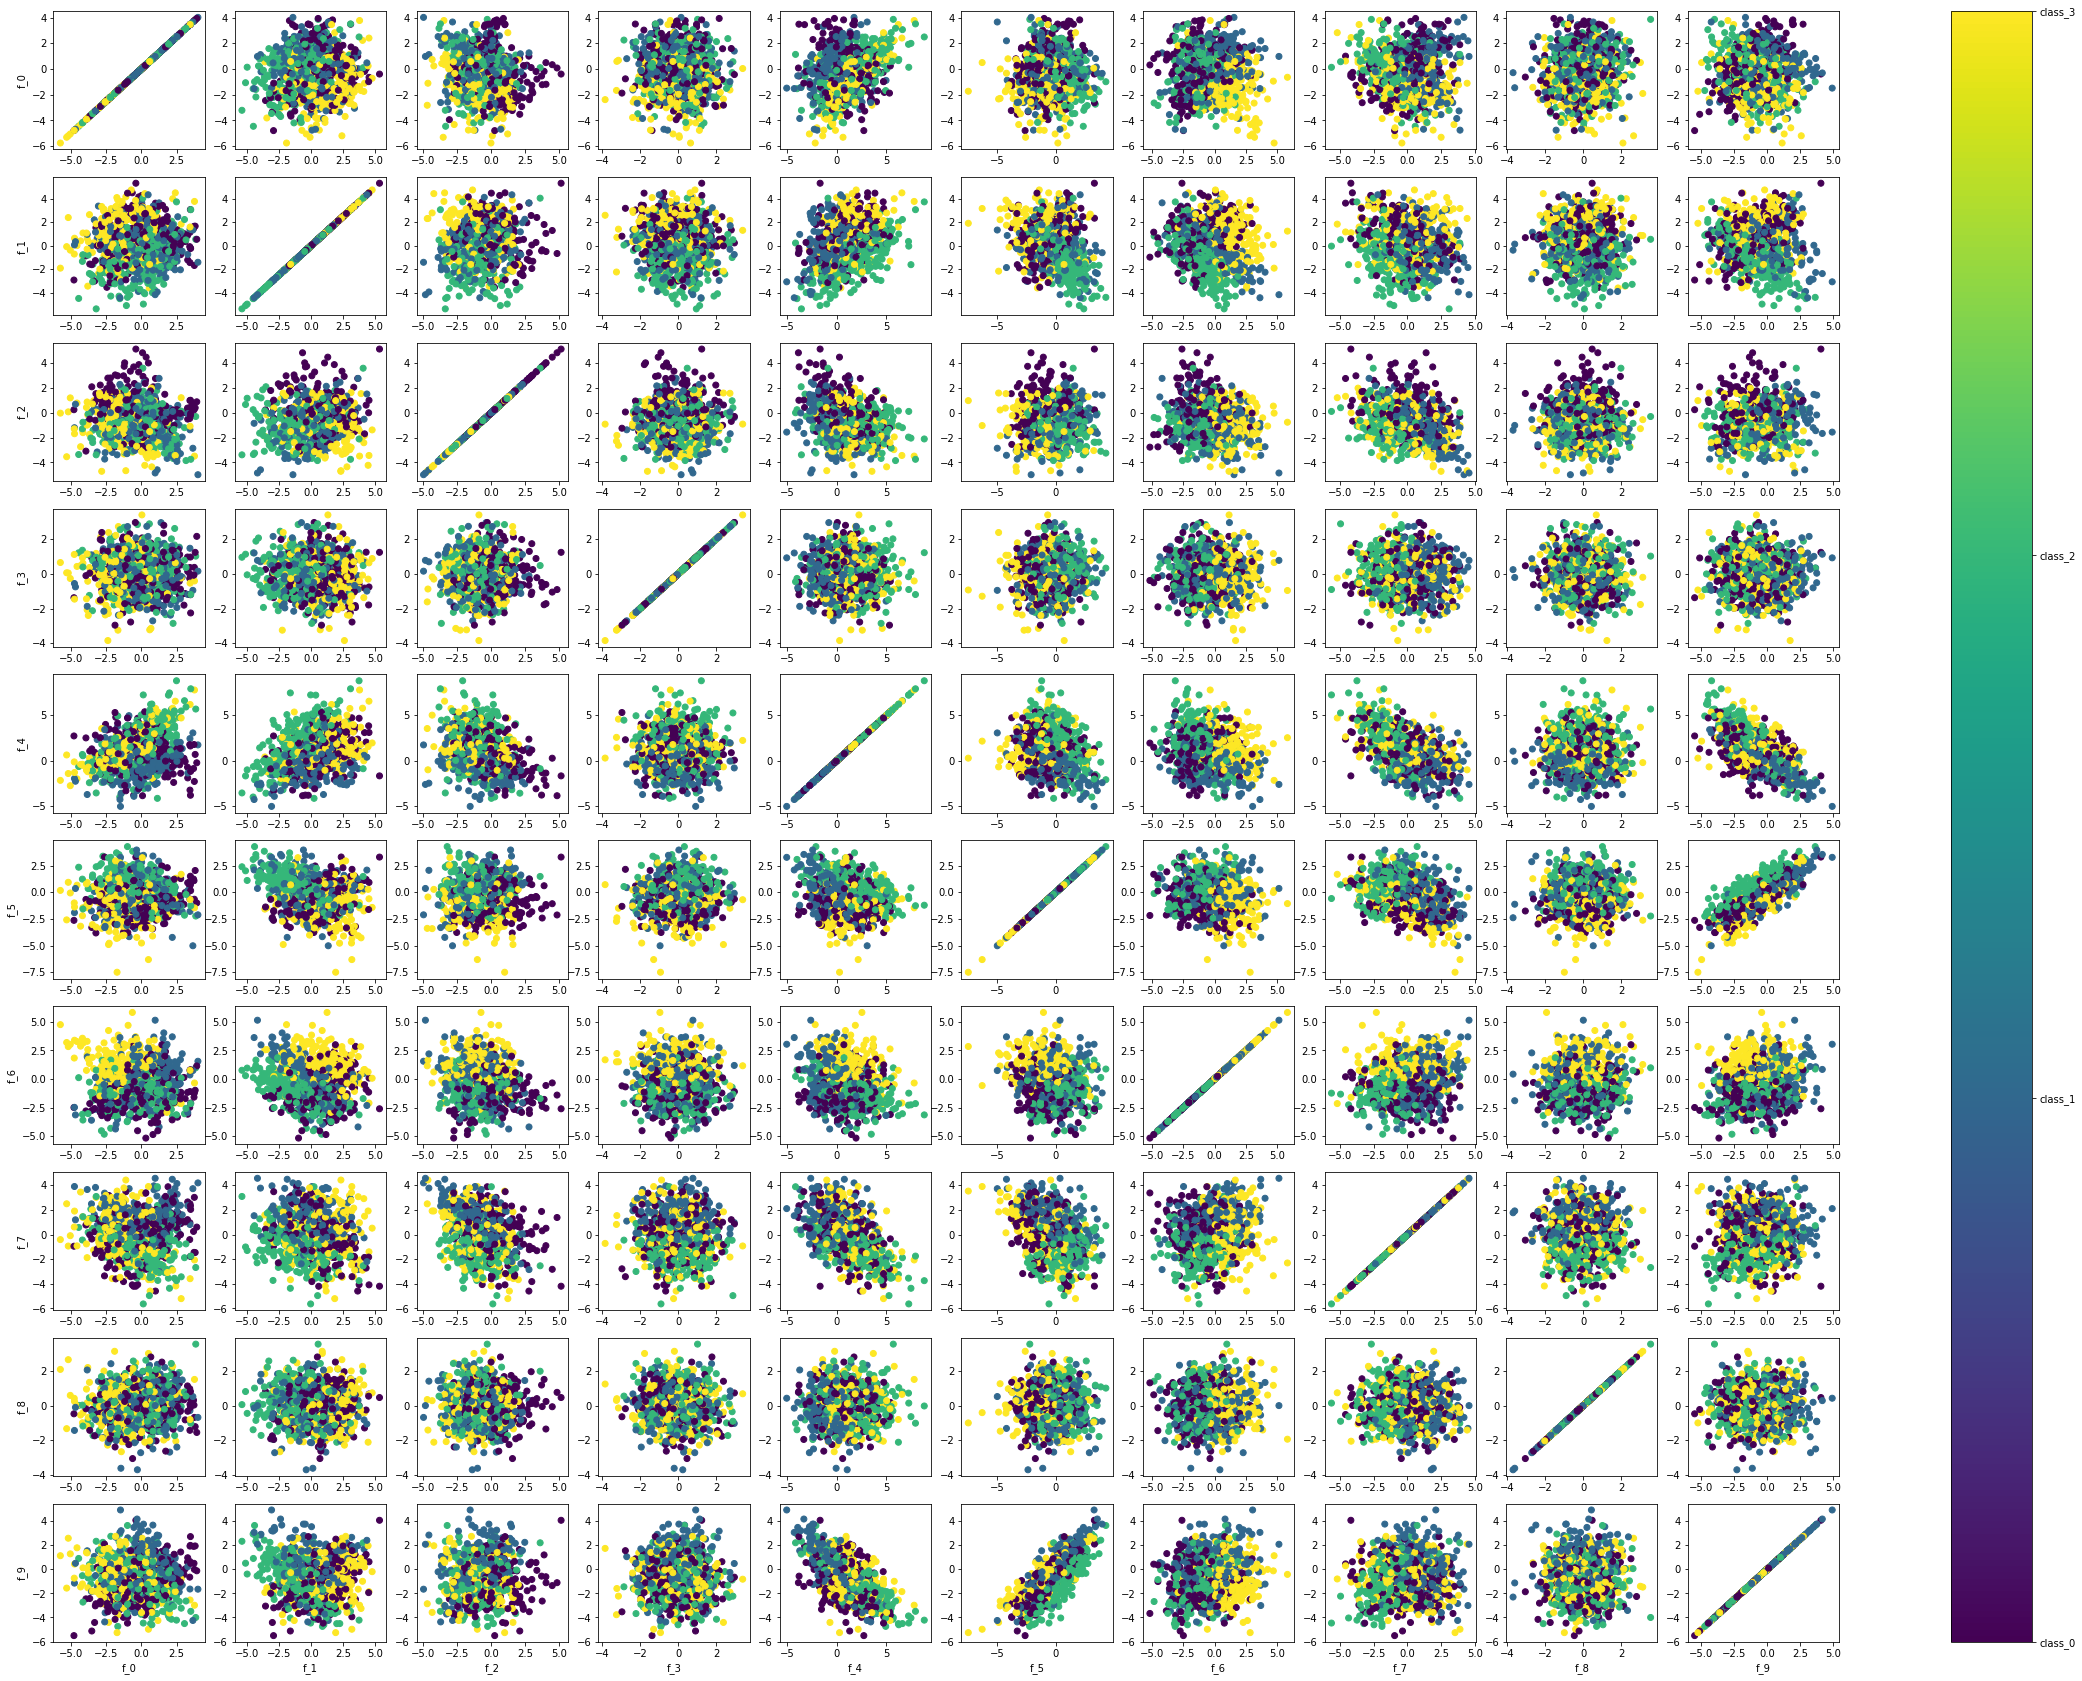

In [6]:
pairplot(data, feature_names, target_names, figsize=(40, 30))

This pairplot is already much more unwieldy than our iris plot, since there are so many features.
This is a randomly generated dataset, so there's less for us to learn from this - but try to see if you can spot the six features that explain the data.

Two features will be redundant. Can you spot those too?

Hint: Some will be random noise, and some will contain signal. You can probably already spot some of them with your eyes. The redundant features will look to be highly correlated.

For more introduction on what to read from this, see [/Guides/01_Data_Analysis](Guides/01_Data_Analysis.ipynb)

In [7]:
#The informative features are:
print(f"""Informative features: {feature_names[:n_informative]},
redundant features: {feature_names[n_informative:n_informative+n_redundant]},
random features: {feature_names[n_informative+n_redundant:]}""")


Informative features: ['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5'],
redundant features: ['f_6', 'f_7'],
random features: ['f_8', 'f_9']


# First, let's do a regular holdout split we can validate against

For more introduction on dataset splitting, see [/Guides/05_Holdout_Validation](Guides/05_Holdout_Validation.ipynb)

In [8]:
# First, we'll take out a holdout set:
X, X_holdout, y, y_holdout = model_selection.train_test_split(data, target, shuffle=True, stratify=None)

## Hyperparameters

Hyperparameters for random forests are quite similar to that of decision trees - though we can now also decide on the amount of trees.

In [9]:
tree_count = 10

# Determines the function used for deciding how to split the data at each branch in the tree
split_criterion = 'entropy' # “gini” for the Gini impurity and “entropy” for the information gain.

# Determines the maximum depth of the tree
max_depth = 2

## Fit a Random Forest classifier

A Random Forest is what we call an "ensemble" model, and can be fitted just like we're used to, but spans over many individual models. 

The way a random forest works, is to train many randomly initialized decision trees and then average over them (or use majority vote in case of classification) to come with the final prediction. This tends to help with generalization, as there'll be many different opinions and even if each tree overfits, the general representation will be more well-distributed - like asking five colleagues with different specialties for advice.

Here we can see a basic one being fit:

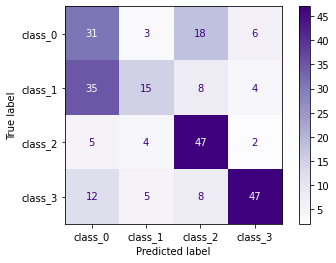

In [10]:
rfc = RandomForestClassifier(n_estimators=tree_count, criterion=split_criterion, max_depth=max_depth, random_state=random_state)
rfc = rfc.fit(X, y)

plot_confusion_matrix(rfc, X_holdout, y_holdout, cmap=plt.cm.Purples, labels=np.unique(target), display_labels=target_names)
plt.show()

We'll later use the accuracy metric to select the best parameters.

Let's first calculate the accuracy on our model above:

In [11]:
y_hat = rfc.predict(X_holdout)

def accuracy(y_true, y_hat):
    error_count = np.sum(y_hat != y_true)
    hit_count = np.sum(y_hat == y_true)
    
    return hit_count / (hit_count+error_count)


print("Accuracy: ", accuracy(y_holdout, y_hat))

Accuracy:  0.56


We can of course also use a metric from sklearn to calculate the same score:

In [12]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_holdout, y_hat)

print("Accuracy: ", acc)

Accuracy:  0.56


## Use K-fold to find the best hyperparameters

Okay, that wasn't quite good enough. Let's see what happens as we increase:

1. the amount of trees in the ensemble
1. The depth of each tree
1. switch between gini and cross-entropy

For more introduction on K-fold cross validation, see [/Guides/06_K_Fold_Cross_Validation](Guides/06_K_Fold_Cross_Validation.ipynb)

## Moving on with the parameter search

This can take a while to run depending on your parameters. watch for the asterisk to the left

In [13]:
# Determines the amount of folds to try on
folds = 3

# Parameters, consider restricting the ranges if going for very high numbers.
min_depth, max_depth = 1, 5
min_trees, max_trees = 1, 10 # Consider freezing the amount of trees if you go very high
criteria = ['entropy', 'gini']

# Initialize the K-fold split generator 
kfold = model_selection.StratifiedKFold(n_splits=folds, random_state=random_state, shuffle=True)

# We'll store out accuracies here, recorded by the parameters we used
accuracies = np.zeros((max_depth, max_trees, 2))

# Let's commence the loop
for depth in range(min_depth, max_depth):
    for trees in range(min_trees, max_trees):
        for c, criterion in enumerate(criteria):
            
            # For each model, we do the same K-fold split, for comparability
            kfold_accs = []
            for train_idx, test_idx in kfold.split(X, y):
                # Split the train and test sets by the folds
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                # Initialize the random forest with our parameters
                rfc = RandomForestClassifier(n_estimators=trees, criterion=criterion, 
                                             max_depth=depth, random_state=random_state)
                
                # Fit the tree to the training data in the split
                rfc = rfc.fit(X_train, y_train)
                
                # Predict and evaluate on the test (validation) set.
                y_hat = rfc.predict(X_test)
                
                # Calculate and store the accuracy for each fold
                acc = accuracy_score(y_test, y_hat)
                kfold_accs.append(acc)
                
            # Store the mean accuracy across folds
            accuracies[depth, trees, c] = np.mean(kfold_accs)

## Measuring the accuracy of our best model (on the validation set)

In [14]:
# Let's first find the best mean accuracy we have on the folds
accuracies.max()

0.6666666666666666

## Plotting the development of accuracy

We can also try to plot the development of accuracy for each value of the hyperparameters, to get an understanding of whether there is room for improvement, or we've "plateau"ed.

We're gonna plot the mean and max values for each hyperparameter, for clarity's sake.

You'll notice plateauing if it is not improving significantly as the parameters increase, and it's usually an indication that there is no further reason to increase the complexity of the model

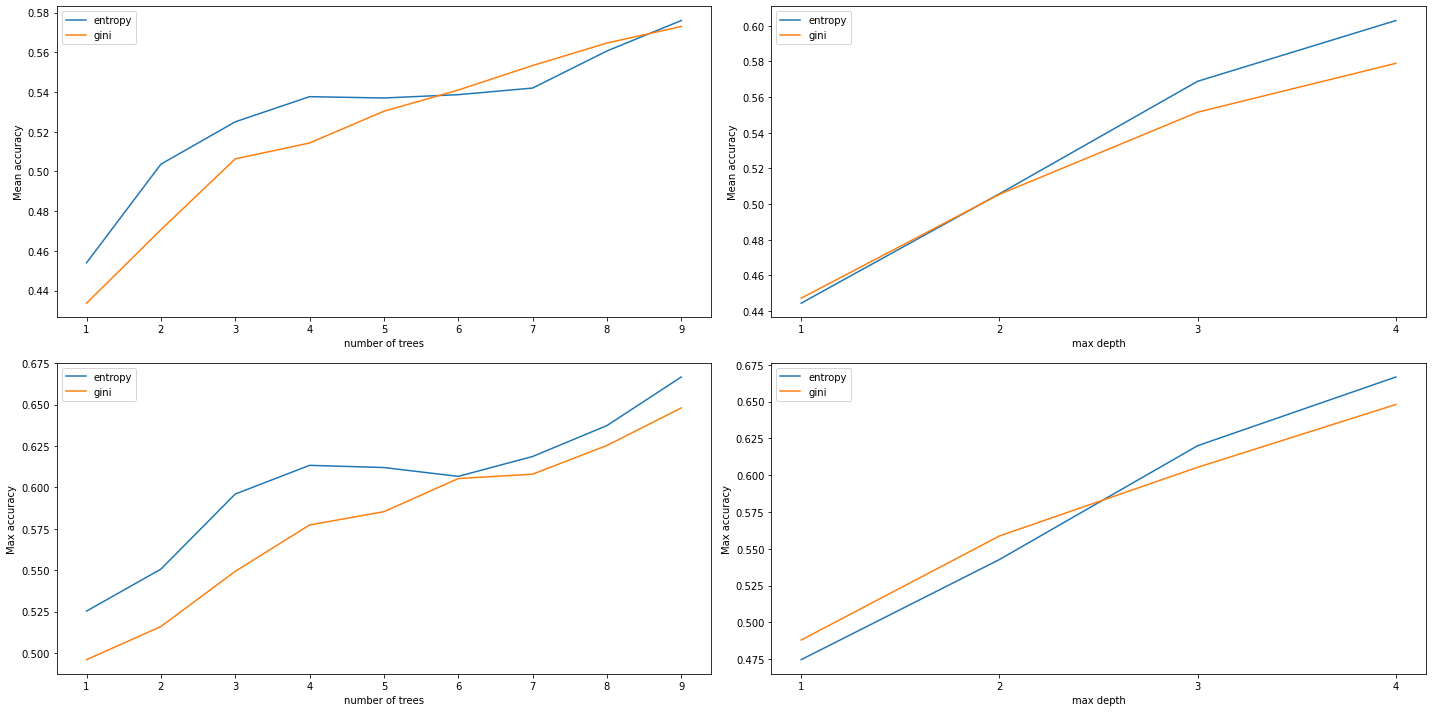

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

x_labels = ['number of trees', 'max depth']
x_ticks = [range(min_trees, max_trees), range(min_depth, max_depth)]
y_labels = ['Mean accuracy', 'Max accuracy']
aggregators = [np.mean, np.max]

for r, row in enumerate(axes):
    for i, ax in enumerate(row):
        aggregator = aggregators[r]
        
        for c, crit in enumerate(criteria):
            plot_data = accuracies[min_depth:,min_trees:,c]
            # Let's compute the mean over amount of trees, and over depth
            agg = aggregator(plot_data, axis=i)

            ax.plot(x_ticks[i], agg, label=crit)
            ax.set_ylabel(y_labels[r])
            ax.set_xlabel(x_labels[i])
            ax.set_xticks(x_ticks[i])
            ax.legend()

plt.tight_layout()
plt.show()

# Selecting the best model

In [16]:
# You'll notice it returns the index of the flattened array. 
flat_index = np.argmax(accuracies)
print(f"Flat index: {flat_index}")

# We're interested in the best parameters from above, so we need to unravel that.
indices = np.unravel_index(flat_index, accuracies.shape)
print(f"Parameterized indices: {indices}")

Flat index: 98
Parameterized indices: (4, 9, 0)


We can use these indices to get the accuracies out (just to double-check)

In [17]:
accuracies[indices]

0.6666666666666666

We can also assign them straight to our optimal parameters

In [18]:
# Expand the indices to variables
n_depth, n_trees, split_criterion_idx = indices
best_criterion = criteria[split_criterion_idx] #Translate the criterion to a name using our criteria list from before

print(f"Trees: {n_trees}, depth: {n_depth}, criterion: {best_criterion}")

Trees: 9, depth: 4, criterion: entropy


# Fitting a final model on the best parameters

We can then fit a random forest on these parameters on the whole training set, like we first did.

We can then check against our holdout to see how it generalizes.

For more introduction to confusion matrices, check out [/Guides/04_Evaluation_and_Confusion_Matrices](Guides/04_Evaluation_and_Confusion_Matrices.ipynb)

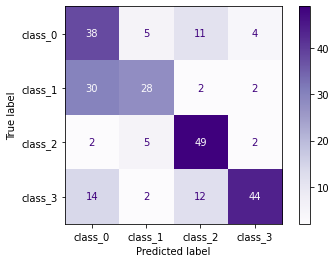

In [19]:
rfc = RandomForestClassifier(n_estimators=n_trees, criterion=best_criterion, max_depth=n_depth, random_state=random_state)
rfc = rfc.fit(X, y)

plot_confusion_matrix(rfc, X_holdout, y_holdout, cmap=plt.cm.Purples, labels=np.unique(target), display_labels=target_names)
plt.show()

You should already see an improvement from the initial simple model we made

In [20]:
print(f"Accuracy on holdout: {accuracy_score(y_holdout, rfc.predict(X_holdout))}")

Accuracy on holdout: 0.636


# Exercise

1. Run the code and read through it to get a feel for what it does
1. Play with the hyper parameter search and try to improve your test score.
    - Does it help to make the trees deeper?
    - What if there's many more trees?
    - Does it help to increase or decrease the amount of folds?
    - Do you get diminishing returns on the improvement?
    - What appears to be the best split criterion?
    - Remember to take notes of your configurations and their results.
    
1. What is the best test accuracy you're able to get?

1. What are the minimum parameters you can use to achieve that?

# Hints

1. Hints for exercise 2
    1. When tweaking the hyperparameters, remember you can define narrow ranges (such as range(10, 15).
    1. Adding more trees to the ensemble will almost always make a more accurate model than fewer - at the cost of computation.

